In [1]:

import os
import re
import csv
import time
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
# four style options:
# white, whitegrid, darkgrid, ticks
sns.set(style='white')
# includes graphs inline with code
%matplotlib inline

# change directory to proper folder
project_path = os.path.dirname(os.path.realpath('__file__'))
os.chdir(project_path)

In [2]:
# load csv data and/or add average walkscore for each neighborhood cluster
dir_list = os.listdir()
if 'Neighborhood_Clusters_W_Walkscore.csv' not in dir_list:
    neighborhood_data = []
    with open('Neighborhood_Clusters.csv',mode='r',encoding='utf-8-sig') as fh:
        csv_obj = csv.reader(fh)
        for row in csv_obj:
            neighborhood_data.append(row)
    row_num = 0
    base_wlkscr_url = 'https://www.walkscore.com/score/'
    for row in neighborhood_data:
        if row_num == 0:
            row.extend(['AV_WLK_SCORE', 'AV_TRNST_SCORE', 'AV_BIKE_SCORE'])
            row_num += 1
            continue
        else:
            city_cluster = row[3].split(',')
            total_wlk_scr = 0
            total_trnst_scr = 0
            total_bike_scr = 0
            num_cities = 0
            for city in city_cluster:
                city = city.strip()
                city_formatted = city.replace(' ', '-')
                wlkscr_page = requests.get(base_wlkscr_url+city_formatted+'-dc', headers={'User-Agent':'Mozilla/5.0'})
                soup = BeautifulSoup(wlkscr_page.text, 'html.parser')
                score_tags = soup.find_all('div', class_='clearfix score-div')
                if len(score_tags) != 3:
                    continue
                wlk_scr_tag = score_tags[0].find('img', src=True, alt=True)
                try:
                    wlk_scr = int(re.findall('/(\d{1,2})\.svg', wlk_scr_tag.get('src'))[0])
                except:
                    wlk_scr = int(re.findall('.*(\d{1,2}).*', wlk_scr_tag.get('alt'))[0])
                total_wlk_scr += wlk_scr
                trnst_scr_tag = score_tags[1].find('img', src=True, alt=True)
                try:
                    trnst_scr = int(re.findall('/(\d{1,2})\.svg', trnst_scr_tag.get('src'))[0])
                except:
                    trnst_scr = int(re.findall('.*(\d{1,2}).*', trnst_scr_tag.get('alt'))[0])
                total_trnst_scr += trnst_scr
                bike_scr_tag = score_tags[2].find('img', src=True, alt=True)
                try:
                    bike_scr = int(re.findall('/(\d{1,2})\.svg', bike_scr_tag.get('src'))[0])
                except:
                    bike_scr = int(re.findall('.*(\d{1,2}).*', bike_scr_tag.get('alt'))[0])
                total_bike_scr += bike_scr
                num_cities += 1
                time.sleep(0.5)
            avg_wlk_scr = total_wlk_scr/num_cities
            avg_trnst_scr = total_trnst_scr/num_cities
            avg_bike_scr = total_bike_scr/num_cities
            row.extend([avg_wlk_scr, avg_trnst_scr, avg_bike_scr])
    with open('Neighborhood_Clusters_W_Walkscore.csv', 'w') as fh:
        writer = csv.writer(fh)
        for row in neighborhood_data:    
            writer.writerow(row)
data = pd.read_csv('Neighborhood_Clusters_W_Walkscore.csv')
data.sample(5)

,OBJECTID,WEB_URL,NAME,NBH_NAMES,TYPE,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,AV_WLK_SCORE,AV_TRNST_SCORE,AV_BIKE_SCORE
3,4,http://planning.dc.gov/,Cluster 17,"Takoma, Brightwood, Manor Park",Original,{5BF4BCEC-5022-4B96-9577-C0246154197C},NaN,NaN,NaN,NaN,0,0,78.000000,64.333333,69.666667
42,43,http://planning.dc.gov/,Cluster 27,"Near Southeast, Navy Yard",Original,{116CB28E-A1A5-44EF-AC79-EE67370ABEC8},NaN,NaN,NaN,NaN,0,0,88.000000,70.500000,93.500000
40,41,http://planning.dc.gov/,Cluster 9,"Southwest Employment Area, Southwest/Waterfron...",Original,{0D85A9B0-AAE1-4EE0-A311-793BC87ED3C5},NaN,NaN,NaN,NaN,0,0,52.750000,45.500000,70.750000
0,1,http://planning.dc.gov/,Cluster 16,"Colonial Village, Shepherd Park, North Portal ...",Original,{8D235E97-D58C-4891-943E-307143103BD9},NaN,NaN,NaN,NaN,0,0,61.333333,71.000000,49.666667
41,42,http://planning.dc.gov/,Cluster 34,"Twining, Fairlawn, Randle Highlands, Penn Bran...",Original,{584E4CF2-BD04-47B0-9D3D-2EBDF1B87F9B},NaN,NaN,NaN,NaN,0,0,58.333333,57.333333,47.166667


In [3]:
# load shapes into geopandas and sample
shapes = 'Neighborhood_Clusters.shp'
neighborhoods = gpd.read_file(shapes)
neighborhoods.sample(5)

,OBJECTID,WEB_URL,NAME,NBH_NAMES,TYPE,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
19,20,http://planning.dc.gov/,Cluster 24,"Woodridge, Fort Lincoln, Gateway",Original,{53775504-7D99-4BAE-8958-2DDD0CC1683C},None,None,None,None,0,0,"POLYGON ((-76.97870 38.94074, -76.97811 38.940..."
22,23,None,Cluster 45,"National Mall, Potomac River",Additional,{BE6A5366-DD25-40D6-A0E6-BF1616E7DA0C},None,None,None,None,0,0,"POLYGON ((-77.11921 38.93456, -77.11919 38.934..."
29,30,http://planning.dc.gov/,Cluster 29,"Eastland Gardens, Kenilworth",Original,{9F4E05D1-06C1-45C0-BC5C-0DA3DABDC596},None,None,None,None,0,0,"POLYGON ((-76.93916 38.91643, -76.93417 38.912..."
23,24,http://planning.dc.gov/,Cluster 3,"Howard University, Le Droit Park, Cardozo/Shaw",Original,{4DD0F1FB-859C-4EAC-BDD0-C712E6DFDCDC},None,None,None,None,0,0,"POLYGON ((-77.01389 38.92627, -77.01357 38.926..."
43,44,http://planning.dc.gov/,Cluster 37,"Sheridan, Barry Farm, Buena Vista",Original,{F3CB149A-426B-4BC1-8048-0BC712086155},None,None,None,None,0,0,"POLYGON ((-76.98347 38.85715, -76.98303 38.856..."


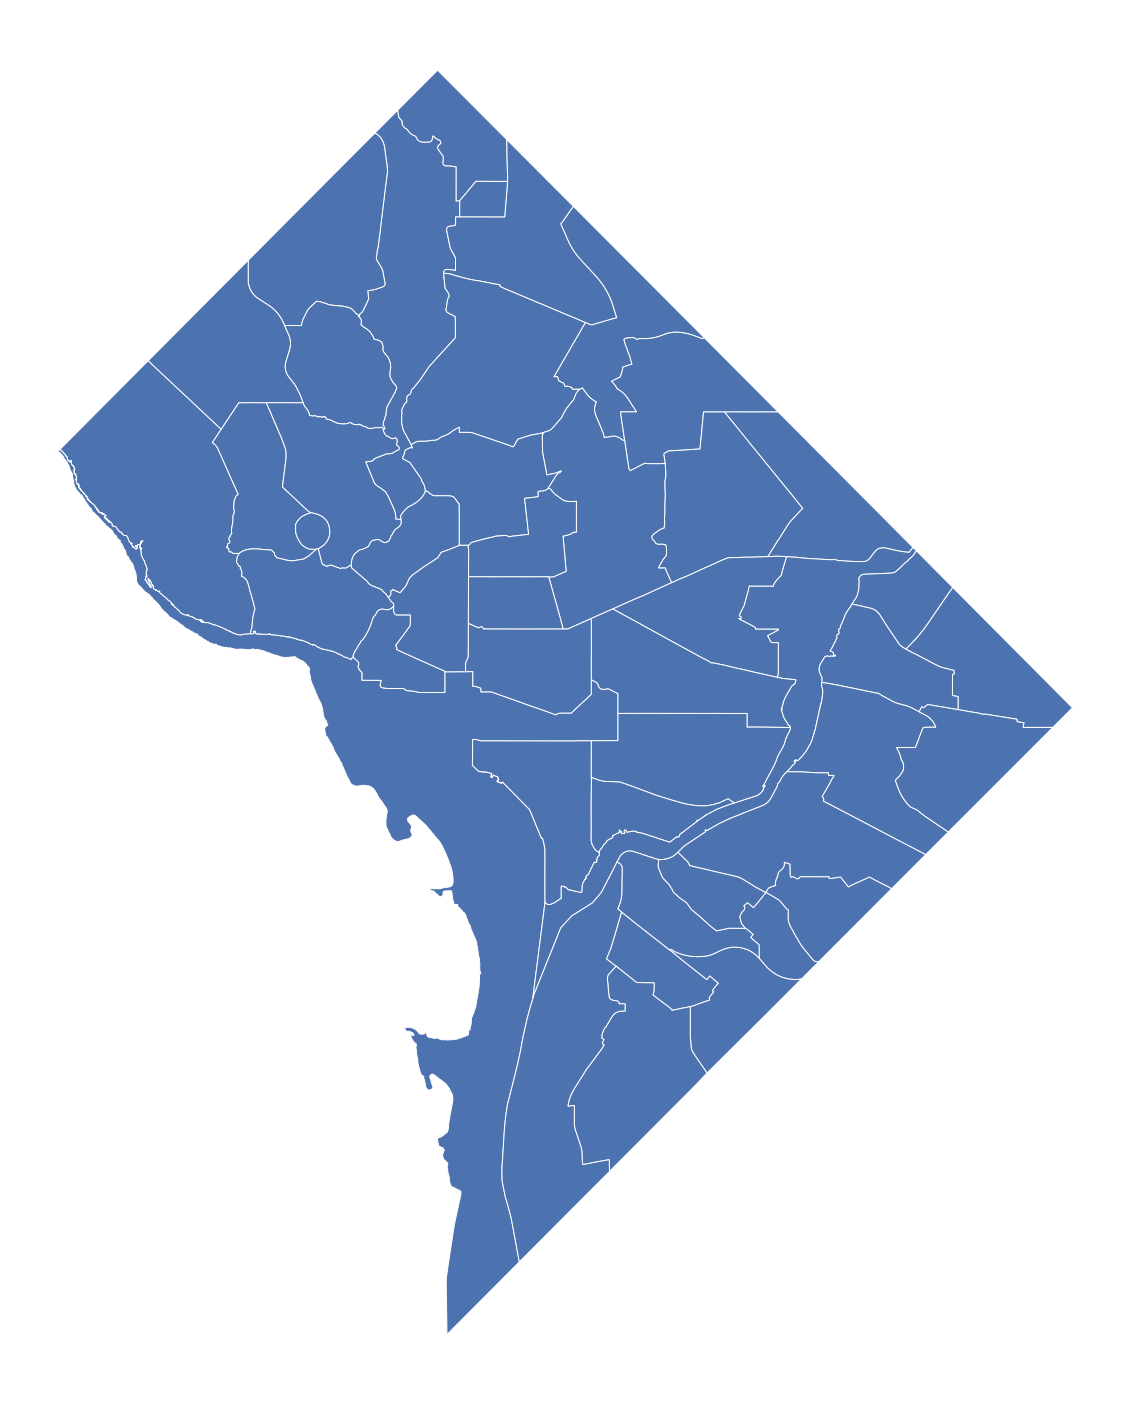

,NAME,NAME,geometry,AV_WLK_SCORE,AV_TRNST_SCORE,AV_BIKE_SCORE
14,Cluster 20,Cluster 20,"POLYGON ((-76.98629 38.95265, -76.98602 38.952...",63.00,63.000000,66.000000
22,Cluster 45,Cluster 45,"POLYGON ((-77.11921 38.93456, -77.11919 38.934...",98.00,96.000000,92.000000
7,Cluster 18,Cluster 18,"POLYGON ((-77.01670 38.94657, -77.01681 38.946...",80.00,60.666667,76.666667
37,Cluster 32,Cluster 32,"POLYGON ((-76.93760 38.88996, -76.93753 38.889...",54.75,61.250000,50.250000
28,Cluster 4,Cluster 4,"POLYGON ((-77.06518 38.91684, -77.06509 38.916...",92.00,59.500000,73.000000


In [4]:
# load regions onto plot
neighborhoods.plot(figsize=(20,40))
plt.axis('off')
plt.show()
# merge datasets 
merged = pd.concat([neighborhoods, data], axis=1)
merged[['NAME', 'geometry', 'AV_WLK_SCORE', 'AV_TRNST_SCORE', 'AV_BIKE_SCORE']].sample(5)

<AxesSubplot:title={'center':'Heat Map of Walkscore by Neighborhood in Washington, DC'}>

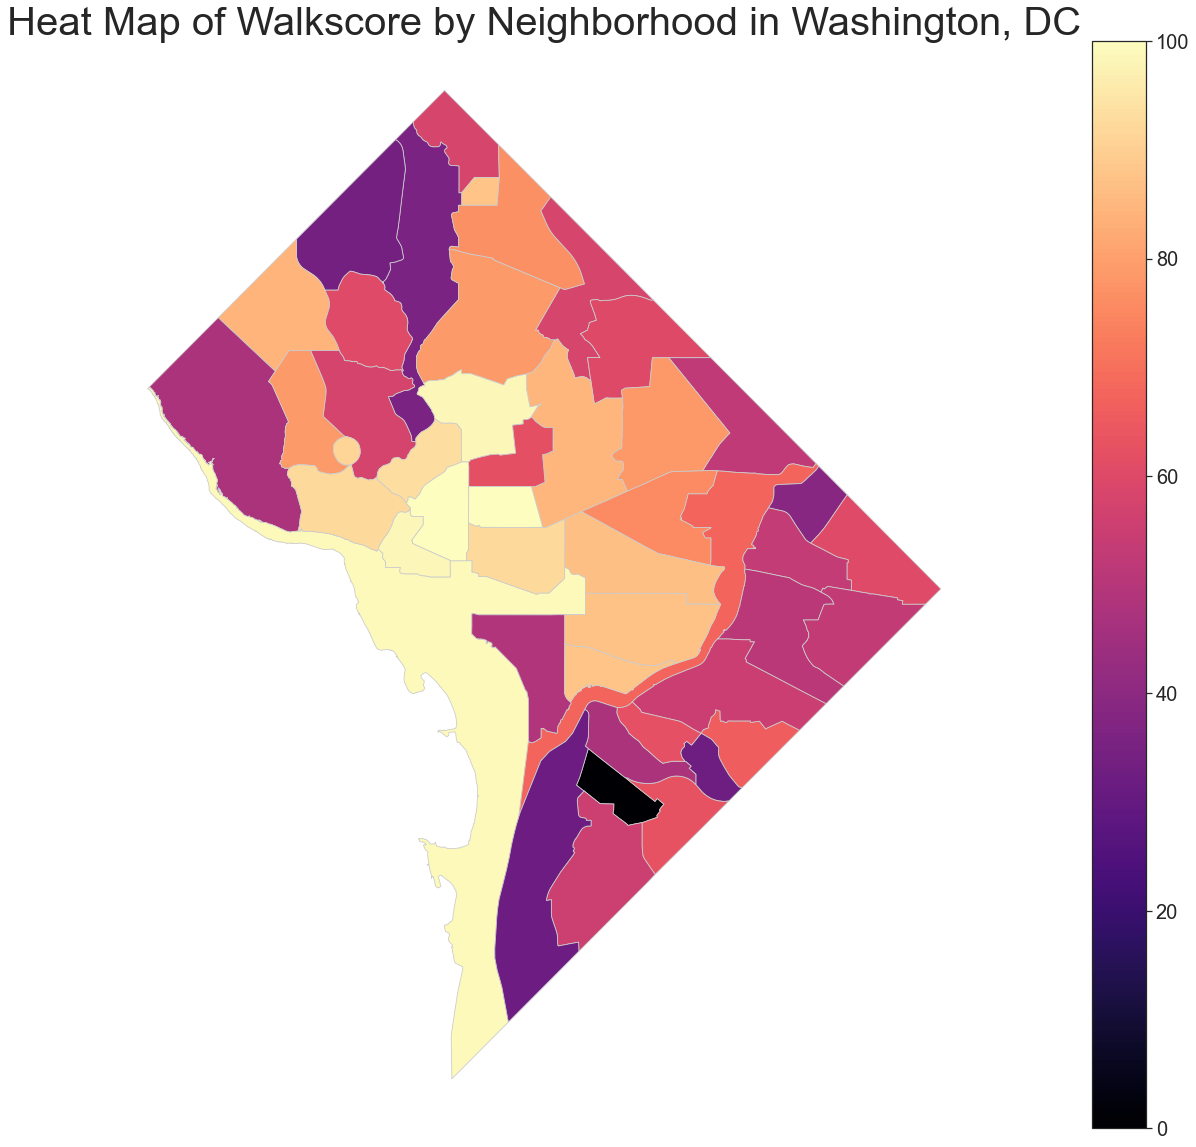

In [5]:
# heatmap by walkscore
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Walkscore by Neighborhood in Washington, DC', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'magma'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('AV_WLK_SCORE', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

<AxesSubplot:title={'center':'Heat Map of Transitscore by Neighborhood in Washington, DC'}>

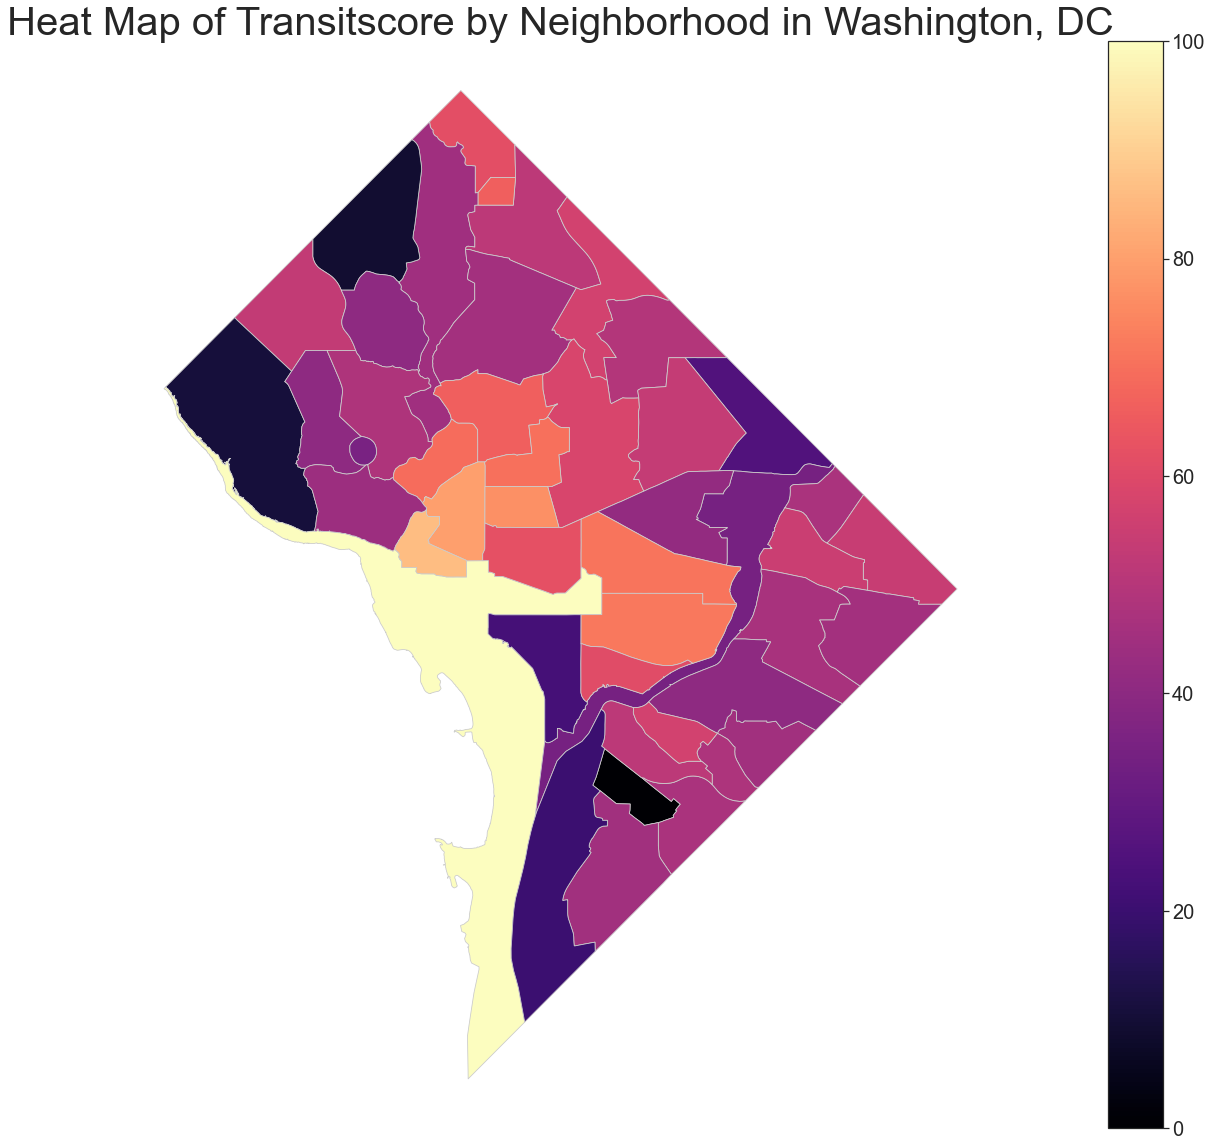

In [6]:
# heatmap by transitscore
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Transitscore by Neighborhood in Washington, DC', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'magma'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('AV_TRNST_SCORE', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

<AxesSubplot:title={'center':'Heat Map of Bikescore by Neighborhood in Washington, DC'}>

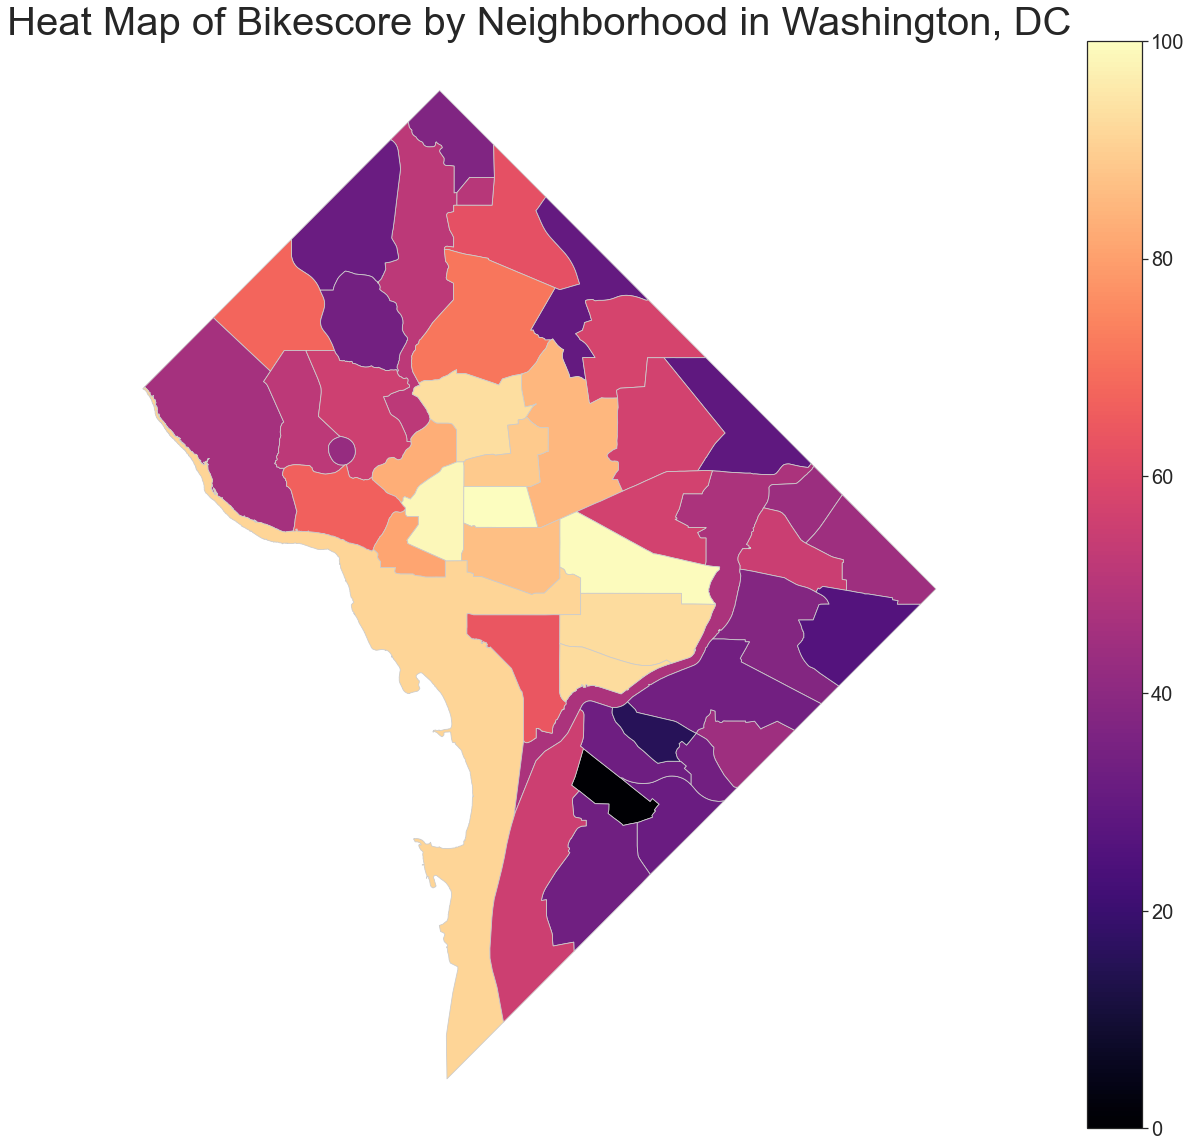

In [7]:
# heatmap by bikescore
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Bikescore by Neighborhood in Washington, DC', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'magma'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('AV_BIKE_SCORE', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))